### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [914]:
import os

import pandas as pd
import xgboost as xgb

In [915]:
print(f"pandas version: {pd.__version__}")
print(f"xgboost version: {xgb.__version__}")

pandas version: 2.2.2
xgboost version: 2.0.3


In [916]:
# if pd.__version__ != "1.5.1":
#     os.system("pip install pandas==1.5.1")

In [917]:
# if xgb.__version__ != "1.3.3":
#     os.system("pip install xgboost==1.3.3")

In [918]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [919]:
# from google.colab import drive
# drive.mount('/content/drive')

In [920]:
# ! pip install xgboost==1.3.3

In [921]:
# if xgb.__version__ != "1.3.3":
#     os.system("pip install xgboost==1.3.3")

In [922]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.26.4
Pandas version 2.2.2
XGBoost version 2.0.3


In [923]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

# DATA_PATH = ""

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [924]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
10983,2013-08-31,52_5820,18,52,35,5820,1999.0,2.0
1989,2014-08-31,21_16169,7,21,65,16169,299.0,7.0
9297,2014-02-28,42_5823,14,42,35,5823,2599.0,6.0
10416,2015-02-28,47_12134,15,47,30,12134,374.0,4.0
4455,2013-10-31,26_7894,7,26,6,7894,1490.0,7.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [925]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [926]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido. 

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u> 

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por **"notebook funcional"** entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Tratar los nulos.
1. Realizar un pequeño EDA sobre el dataset.
1. Crear algunas variables rápidas para el entrenamiento.
1. Entrenar el algoritmo.
1. Evaluar el modelo.
1. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 426 Series Temporales en el dataset:

In [927]:
df["unique_id"].nunique()

426

Veamos cuales son las fechas min y max de nuestro dataset:

In [928]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [929]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [930]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [931]:
df.fillna({"monthly_sales":0}, inplace = True)
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.bfill().ffill()
)

In [932]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [933]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [934]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: más de 400 Series Temporales diferentes tendríamos que entrenar 400 ARIMAs (1 modelo por Serie Temporal). En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 400 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

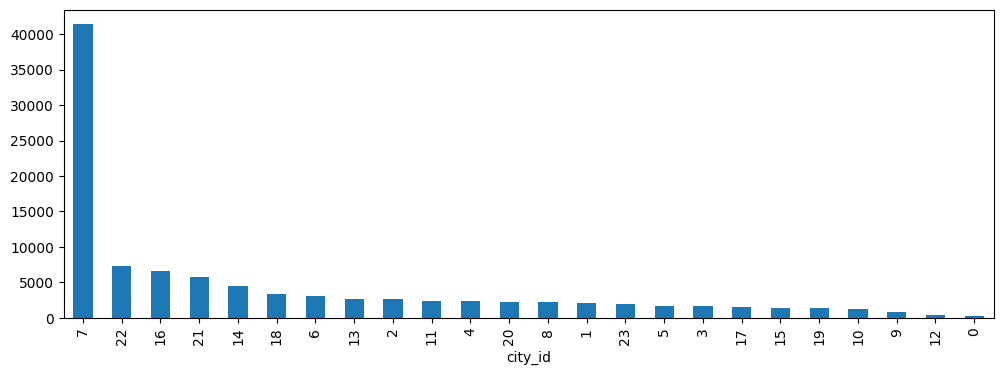

In [935]:
(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

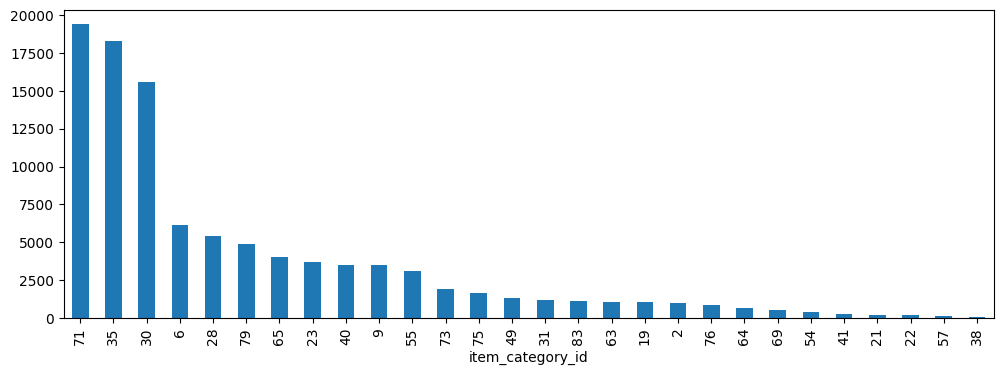

In [936]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [937]:
df["revenue"] = df["monthly_average_price"] * df["monthly_sales"]
#df["revenue_lag1"] = df.groupby('unique_id')["revenue"].shift(1)

In [938]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):
    
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("ME")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
        
    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_lag2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_

In [939]:
GB_LIST = ["item_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_.head(10)

C:\Users\UX433F\AppData\Local\Temp\ipykernel_24984\4192736170.py:12: FutureWarning: The provided callable <function sum at 0x00000263CAE58720> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage item_id_monthly_sales_sum


,item_id,date,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2
0,32,2013-01-31,NaN,NaN
1,32,2013-02-28,24.0,NaN
2,32,2013-03-31,20.0,24.0
3,32,2013-04-30,13.0,20.0
4,32,2013-05-31,11.0,13.0
5,32,2013-06-30,6.0,11.0
6,32,2013-07-31,11.0,6.0
7,32,2013-08-31,10.0,11.0
8,32,2013-09-30,9.0,10.0
9,32,2013-10-31,2.0,9.0


In [940]:
vars_revenue_ = build_ts_vars(
    df = df,
    gb_list = ["item_id"],
    target_column = "revenue",
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_revenue_.head(10)

C:\Users\UX433F\AppData\Local\Temp\ipykernel_24984\4192736170.py:12: FutureWarning: The provided callable <function sum at 0x00000263CAE58720> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage item_id_revenue_sum


,item_id,date,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2
0,32,2013-01-31,NaN,NaN
1,32,2013-02-28,8376.0,NaN
2,32,2013-03-31,6980.0,8376.0
3,32,2013-04-30,4537.0,6980.0
4,32,2013-05-31,3839.0,4537.0
5,32,2013-06-30,2094.0,3839.0
6,32,2013-07-31,3839.0,2094.0
7,32,2013-08-31,3490.0,3839.0
8,32,2013-09-30,3141.0,3490.0
9,32,2013-10-31,698.0,3141.0


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [941]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500
...,...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0,2690.000000
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0,13449.500000


In [942]:
vars_ts_

,item_id,date,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2
0,32,2013-01-31,NaN,NaN
1,32,2013-02-28,24.0,NaN
2,32,2013-03-31,20.0,24.0
3,32,2013-04-30,13.0,20.0
4,32,2013-05-31,11.0,13.0
...,...,...,...,...
4483,22088,2015-06-30,17.0,13.0
4484,22088,2015-07-31,10.0,17.0
4485,22088,2015-08-31,20.0,10.0
4486,22088,2015-09-30,24.0,20.0


In [943]:
GB_LIST

['item_id']

In [944]:
print(df.shape)

df = pd.merge(df, vars_ts_, on = ["date", "item_id"], how = "left")
df = pd.merge(df, vars_revenue_, on = ["date", "item_id"], how = "left")

print(df.shape)

(14484, 9)
(14484, 13)


In [945]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,30.0,NaN,45345.378788,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,27.0,30.0,41394.375000,45345.378788
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,30.0,27.0,97574.107143,41394.375000
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,27.0,30.0,42943.909091,97574.107143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000,28.0,28.0,79519.966667,80820.000000
14480,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0,2690.000000,43.0,28.0,109115.666667,79519.966667
14481,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000,37.0,43.0,104580.000000,109115.666667
14482,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0,13449.500000,38.0,37.0,94619.000000,104580.000000


# Eze features one by one

In [946]:
# replace imputed values in target to NaN for date 2015-10-31 (test df)
# test_index = [sorted(list(df["date"].unique()))[-1]]
# df['monthly_sales'] = np.where(df['date'].isin(test_index), np.nan, df['monthly_sales'])

In [947]:
#Eze features
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['around_Xmas'] = df['date'].dt.month.isin([1,12]).astype(int)

In [948]:
df['std'] = df.groupby('unique_id')['monthly_sales'].transform(np.std)
#df['mean'] = df.groupby('unique_id')['monthly_sales'].transform(np.mean)
df['max'] = df.groupby('unique_id')['monthly_sales'].transform(np.max)
df['min'] = df.groupby('unique_id')['monthly_sales'].transform(np.min)

C:\Users\UX433F\AppData\Local\Temp\ipykernel_24984\2389298342.py:1: FutureWarning: The provided callable <function std at 0x00000263CAE59940> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df['std'] = df.groupby('unique_id')['monthly_sales'].transform(np.std)
C:\Users\UX433F\AppData\Local\Temp\ipykernel_24984\2389298342.py:3: FutureWarning: The provided callable <function max at 0x00000263CAE58E00> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['max'] = df.groupby('unique_id')['monthly_sales'].transform(np.max)
C:\Users\UX433F\AppData\Local\Temp\ipykernel_24984\2389298342.py:4: FutureWarning: The provided callable <function min at 0x00000263CAE58F40> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callab

In [949]:
# Transformar 'month' en sus representaciones seno y coseno
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df.drop('month', inplace = True, axis = 1)

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [950]:
COLUMNS_TO_DROP = [
    "revenue"
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [951]:
df.set_index("unique_id", inplace = True)

In [952]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

In [953]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [954]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

## Target encoding before fit

In [955]:
cols_to_encode = df.columns[1:5]
df[cols_to_encode] = df[cols_to_encode].astype('category')

In [956]:
train = df[df["date"].isin(train_index)]
valida = df[df["date"].isin(valida_index)]
test = df[df["date"].isin(test_index)]

In [957]:
import category_encoders as ce
# Initialize Targetce2
ce2 = ce.TargetEncoder(cols=cols_to_encode)
# Fit and transform the training data
train_encoded = ce2.fit_transform(train[['shop_id', 'item_id', 'city_id', 'item_category_id', 'date']], train['monthly_sales'])
valida_encoded = ce2.transform(valida[['shop_id', 'item_id', 'city_id', 'item_category_id', 'date']], valida['monthly_sales'])
test_encoded = ce2.transform(test[['shop_id', 'item_id', 'city_id', 'item_category_id', 'date']], test['monthly_sales'])

c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\ordinal.py:198: Fu

In [958]:
X_train_encoded = pd.concat([train.drop(cols_to_encode, axis=1), train_encoded[cols_to_encode]], axis=1)
X_train_encoded.drop(['monthly_sales', "date"], axis=1, inplace=True)
X_valida_encoded = pd.concat([valida.drop(cols_to_encode, axis=1), valida_encoded[cols_to_encode]], axis=1)
X_valida_encoded.drop(['monthly_sales', "date"], axis=1, inplace=True)
X_test_encoded = pd.concat([test.drop(cols_to_encode, axis=1), test_encoded[cols_to_encode]], axis=1)
X_test_encoded.drop(['monthly_sales', "date"], axis=1, inplace=True)

<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [959]:
Y_valida.info()

<class 'pandas.core.series.Series'>
Index: 426 entries, 12_11365 to 7_7893
Series name: monthly_sales
Non-Null Count  Dtype  
--------------  -----  
426 non-null    float64
dtypes: float64(1)
memory usage: 6.7+ KB


In [960]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175, n_estimators = 100)

""" model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
    verbose = True,
    early_stopping_rounds = 15
) """

#If target encoding
model.fit(
    X_train_encoded,
    Y_train,
    eval_set = [(X_train_encoded, Y_train), (X_valida_encoded, Y_valida)],
    verbose = True,
    early_stopping_rounds = 20
)

[0]	validation_0-rmse:6.30040	validation_1-rmse:5.85217
[1]	validation_0-rmse:5.31076	validation_1-rmse:4.84485
[2]	validation_0-rmse:4.67281	validation_1-rmse:4.16753
[3]	validation_0-rmse:4.32520	validation_1-rmse:3.86267
[4]	validation_0-rmse:4.07551	validation_1-rmse:3.62182
[5]	validation_0-rmse:3.91287	validation_1-rmse:3.45620
[6]	validation_0-rmse:3.78051	validation_1-rmse:3.43612
[7]	validation_0-rmse:3.69006	validation_1-rmse:3.37975
[8]	validation_0-rmse:3.58429	validation_1-rmse:3.32879
[9]	validation_0-rmse:3.52517	validation_1-rmse:3.33300
[10]	validation_0-rmse:3.48464	validation_1-rmse:3.31071
[11]	validation_0-rmse:3.41809	validation_1-rmse:3.26865
[12]	validation_0-rmse:3.35603	validation_1-rmse:3.25953
[13]	validation_0-rmse:3.31780	validation_1-rmse:3.27070
[14]	validation_0-rmse:3.27798	validation_1-rmse:3.27507
[15]	validation_0-rmse:3.22151	validation_1-rmse:3.23732
[16]	validation_0-rmse:3.18480	validation_1-rmse:3.23325
[17]	validation_0-rmse:3.15368	validation

c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:2.85975	validation_1-rmse:3.28633
[30]	validation_0-rmse:2.84189	validation_1-rmse:3.27959
[31]	validation_0-rmse:2.83262	validation_1-rmse:3.28047
[32]	validation_0-rmse:2.81371	validation_1-rmse:3.28288
[33]	validation_0-rmse:2.80139	validation_1-rmse:3.28028
[34]	validation_0-rmse:2.78614	validation_1-rmse:3.29318
[35]	validation_0-rmse:2.76480	validation_1-rmse:3.28254


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

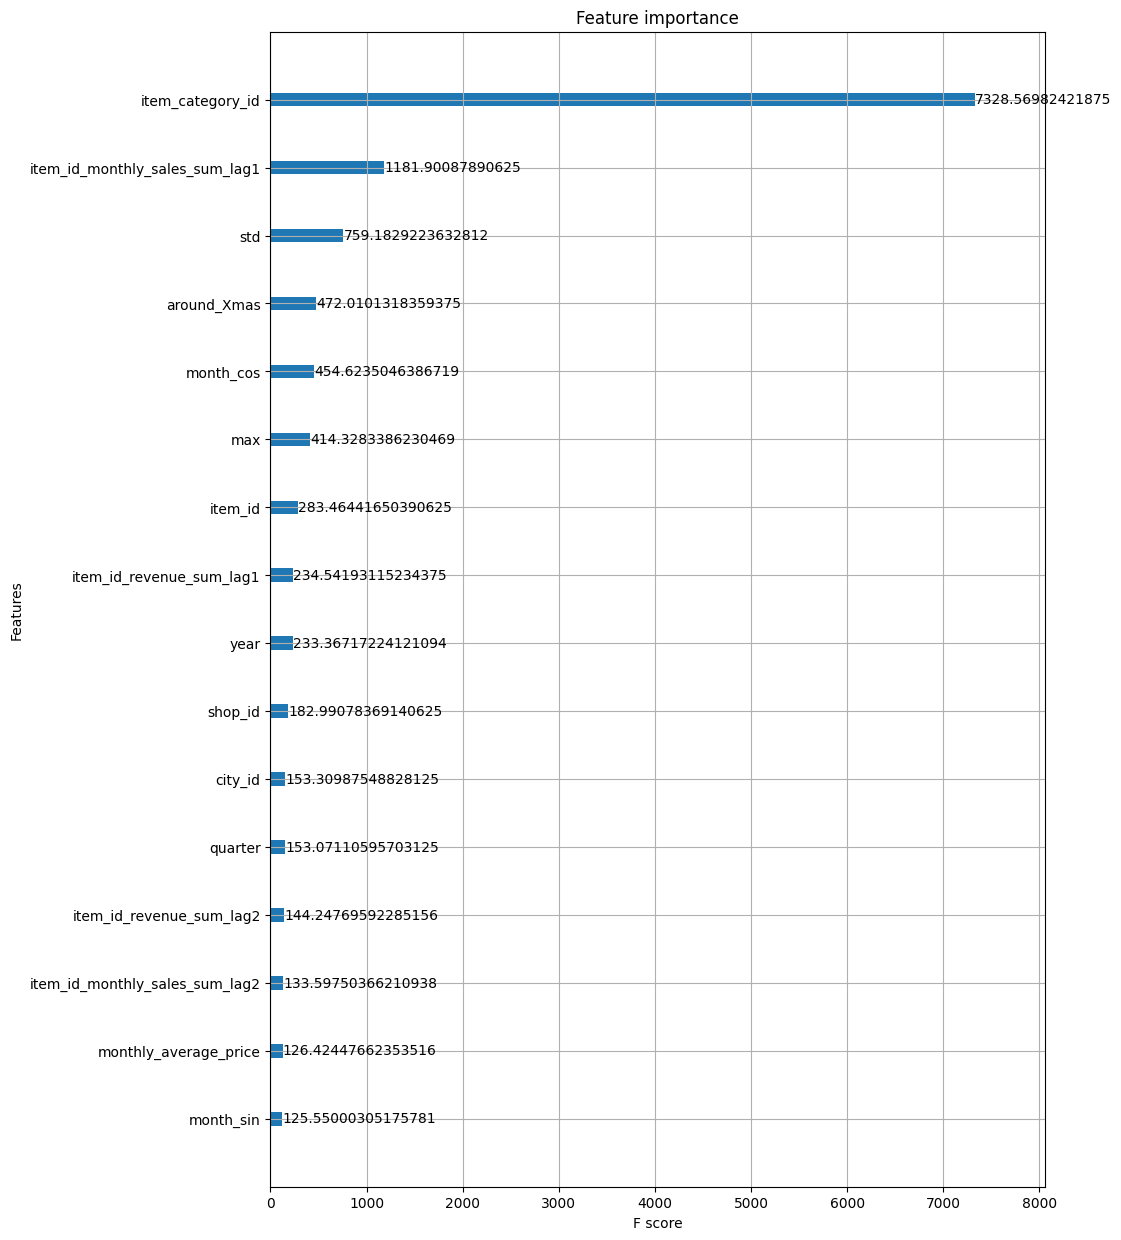

In [961]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [962]:
df.corr().style.background_gradient(cmap='coolwarm')

c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2,year,quarter,around_Xmas,std,max,min,month_sin,month_cos
date,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.047138,-0.026539,0.061530,0.070253,0.063046,0.070457,0.941461,0.224073,-0.104168,0.000000,-0.000000,nan,-0.243492,-0.066856
city_id,-0.000000,1.000000,0.392969,-0.070485,-0.031600,-0.058809,0.030282,0.023481,0.023767,-0.037922,-0.037431,-0.000000,-0.000000,0.000000,0.063079,0.068556,nan,0.000000,-0.000000
shop_id,0.000000,0.392969,1.000000,-0.063615,-0.006660,-0.080010,-0.062285,-0.057530,-0.057094,-0.065116,-0.064315,-0.000000,-0.000000,-0.000000,-0.040821,-0.011975,nan,0.000000,-0.000000
item_category_id,-0.000000,-0.070485,-0.063615,1.000000,0.538650,-0.258021,0.217967,0.205261,0.201603,-0.197823,-0.200612,0.000000,0.000000,-0.000000,0.295073,0.143443,nan,-0.000000,0.000000
item_id,0.000000,-0.031600,-0.006660,0.538650,1.000000,-0.347356,0.280281,0.279384,0.275948,-0.206845,-0.208752,-0.000000,0.000000,0.000000,0.325555,0.166507,nan,-0.000000,0.000000
monthly_average_price,0.047138,-0.058809,-0.080010,-0.258021,-0.347356,1.000000,-0.110573,-0.131778,-0.128247,0.467290,0.468881,0.049443,-0.002776,-0.009974,-0.097040,-0.025458,nan,-0.000172,-0.007422
monthly_sales,-0.026539,0.030282,-0.062285,0.217967,0.280281,-0.110573,1.000000,0.649082,0.627676,0.164273,0.138857,-0.033344,0.001591,0.113279,0.634134,0.541509,nan,0.029578,0.077611
item_id_monthly_sales_sum_lag1,0.061530,0.023481,-0.057530,0.205261,0.279384,-0.131778,0.649082,1.000000,0.972542,0.381142,0.342503,0.070504,-0.023185,0.067467,0.542689,0.404489,nan,0.022488,0.062341
item_id_monthly_sales_sum_lag2,0.070253,0.023767,-0.057094,0.201603,0.275948,-0.128247,0.627676,0.972542,1.000000,0.352303,0.384293,0.082654,-0.041241,0.016683,0.540352,0.403534,nan,0.048574,0.047019
item_id_revenue_sum_lag1,0.063046,-0.037922,-0.065116,-0.197823,-0.206845,0.467290,0.164273,0.381142,0.352303,1.000000,0.939918,0.088887,-0.069123,0.092435,0.112422,0.166430,nan,0.080732,0.089473


<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [963]:
# Y_train_predict = model.predict(X_train)
# Y_valida_predict = model.predict(X_valida)

Y_train_predict = model.predict(X_train_encoded)
Y_valida_predict = model.predict(X_valida_encoded)

In [964]:
""" # If target is log1p
Y_train = np.expm1(Y_train)
Y_valida = np.expm1(Y_valida)
Y_train_predict = np.expm1(Y_train_predict)
Y_valida_predict = np.expm1(Y_valida_predict) """

' # If target is log1p\nY_train = np.expm1(Y_train)\nY_valida = np.expm1(Y_valida)\nY_train_predict = np.expm1(Y_train_predict)\nY_valida_predict = np.expm1(Y_valida_predict) '

In [965]:
rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [966]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 3_185
Validation RMSE: 3_233


In [967]:
f"submission_train_{rmse_train}_valida_{rmse_valida}.csv"

'submission_train_3_185_valida_3_233.csv'

# Prediction on test

In [968]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict
X_test.reset_index(inplace = True)

ValueError: feature_names mismatch: ['monthly_average_price', 'item_id_monthly_sales_sum_lag1', 'item_id_monthly_sales_sum_lag2', 'item_id_revenue_sum_lag1', 'item_id_revenue_sum_lag2', 'year', 'quarter', 'around_Xmas', 'std', 'max', 'min', 'month_sin', 'month_cos', 'city_id', 'shop_id', 'item_category_id', 'item_id'] ['city_id', 'shop_id', 'item_category_id', 'item_id', 'monthly_average_price', 'item_id_monthly_sales_sum_lag1', 'item_id_monthly_sales_sum_lag2', 'item_id_revenue_sum_lag1', 'item_id_revenue_sum_lag2', 'year', 'quarter', 'around_Xmas', 'std', 'max', 'min', 'month_sin', 'month_cos']

In [ ]:
""" (
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
) """

' (\n    X_test[["unique_id", "monthly_sales"]]\n    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)\n) '

# Prediction on test with train+valid

In [ ]:
X_train = df[~df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[~df["date"].isin(test_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

In [ ]:
""" model = xgb.XGBRegressor(n_estimators = 100, random_state = 23)

model.fit(
    X_train,
    Y_train,
    verbose = True,
) """

' model = xgb.XGBRegressor(n_estimators = 100, random_state = 23)\n\nmodel.fit(\n    X_train,\n    Y_train,\n    verbose = True,\n) '

In [ ]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict
X_test.reset_index(inplace = True)

In [ ]:
""" (
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_fulltrain_{rmse_train}_valida_{rmse_valida}.csv", index = False)
) """

' (\n    X_test[["unique_id", "monthly_sales"]]\n    .to_csv(f"submission_fulltrain_{rmse_train}_valida_{rmse_valida}.csv", index = False)\n) '

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)